In [1]:
%cd ..
%pwd

/home/user/Documents/Uni/Master/PP2/pp2-2023


'/home/user/Documents/Uni/Master/PP2/pp2-2023'

In [2]:
import math
from pathlib import Path
from typing import Union

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from Bio import SeqIO

from src.dataset.trizod_scores.parse import read_reference_json, read_score_csv
from src.utils.seaborn_plotting import SeabornPlotting

sns.set_theme()

In [3]:
def read_cluster_assignments(filepath: Union[Path, str]) -> pl.DataFrame:
    return pl.read_csv(
        filepath,
        separator="\t",
        has_header=False,
        new_columns=["cluster_representative_id", "sequence_id"]
    )

### Cluster size distribution

Text(0.02, 0.5, '# clusters')

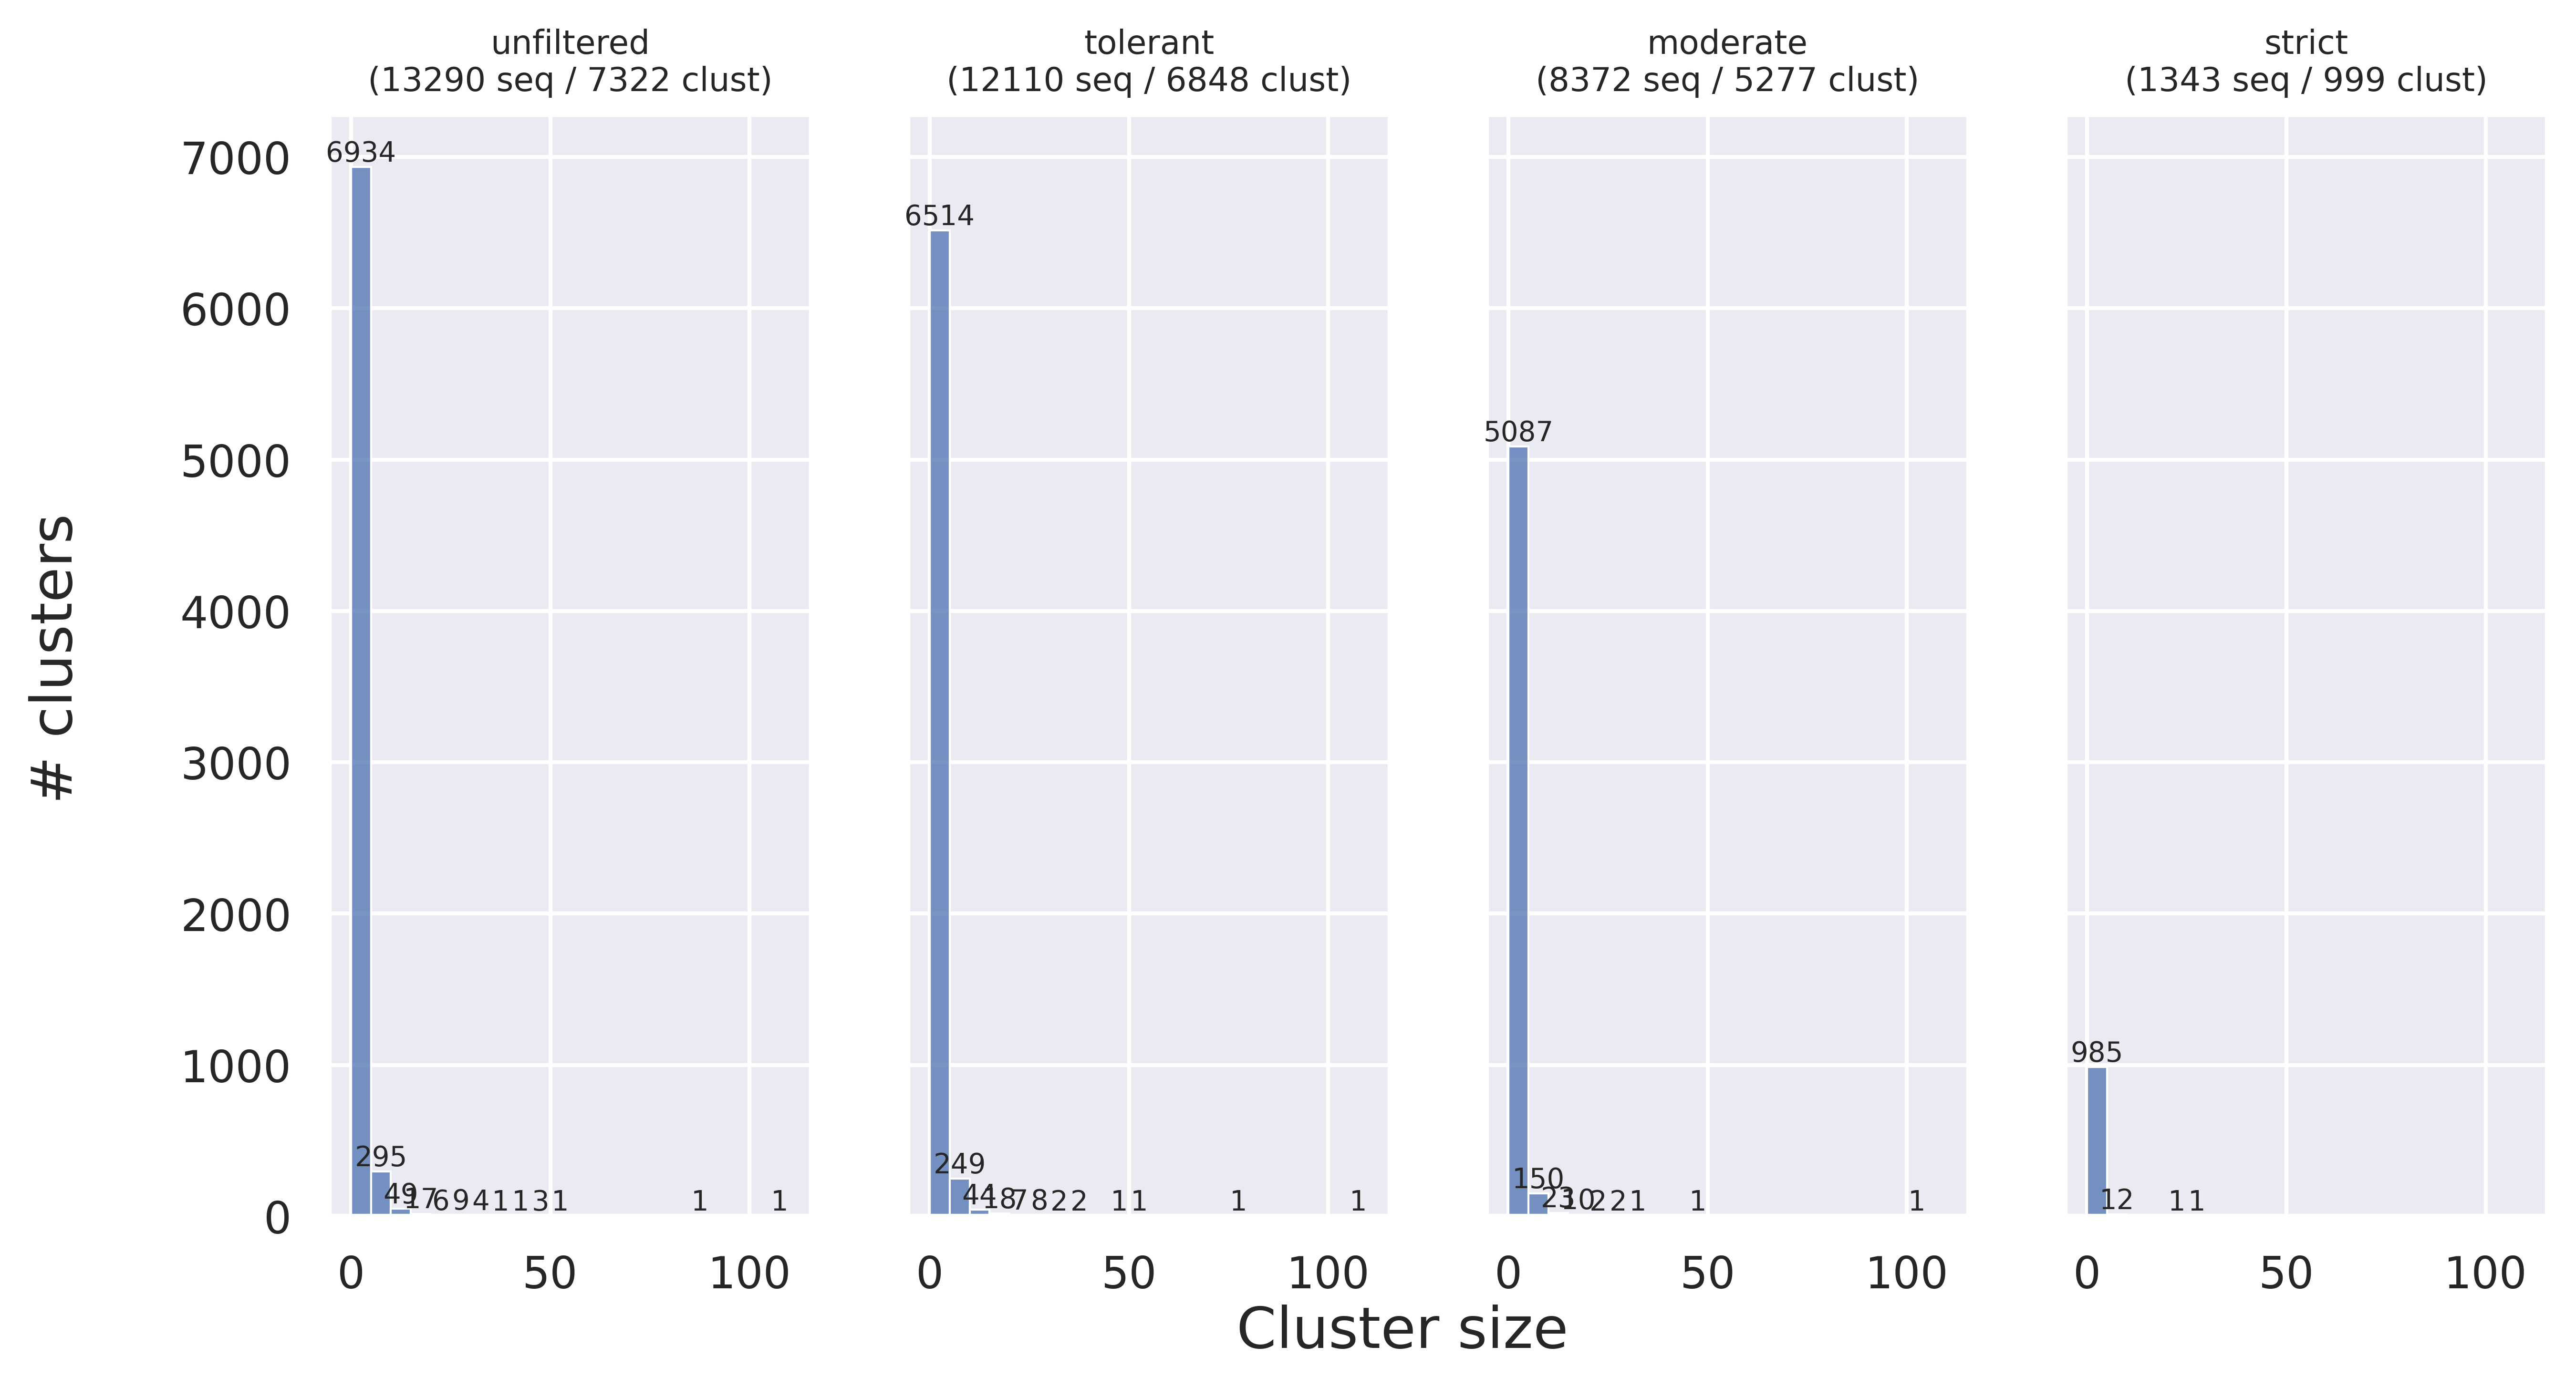

In [4]:
datasets = ["unfiltered", "tolerant", "moderate", "strict"]
clusters = [read_cluster_assignments(f"data/clusters/{dataset}_rest_clu.tsv") for dataset in datasets]
fig, axes = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=(10, 5), dpi=600)

for data, ax, dataset in zip(clusters, axes, datasets):
    cluster_sizes = data.group_by("cluster_representative_id").count()
    plt.sca(ax)
    plot = cluster_sizes.sns.histplot(x="count", binwidth=5, binrange=[0, 110])

    labels = [str(x) if x else '' for x in plot.containers[0].datavalues]
    plot.bar_label(plot.containers[0], labels=labels, fontsize="xx-small")

    n_sequences = data.select(pl.col("sequence_id")).n_unique()
    n_clusters = data.select(pl.col("cluster_representative_id")).n_unique()
    ax.set_title(f"{dataset}\n({n_sequences} seq / {n_clusters} clust)", fontsize="x-small")

    ax.set_xlabel(None)
    ax.set_ylabel(None)

fig.supxlabel("Cluster size")
fig.supylabel("# clusters")

### Sequence length distribution

Text(0.02, 0.5, '% sequences')

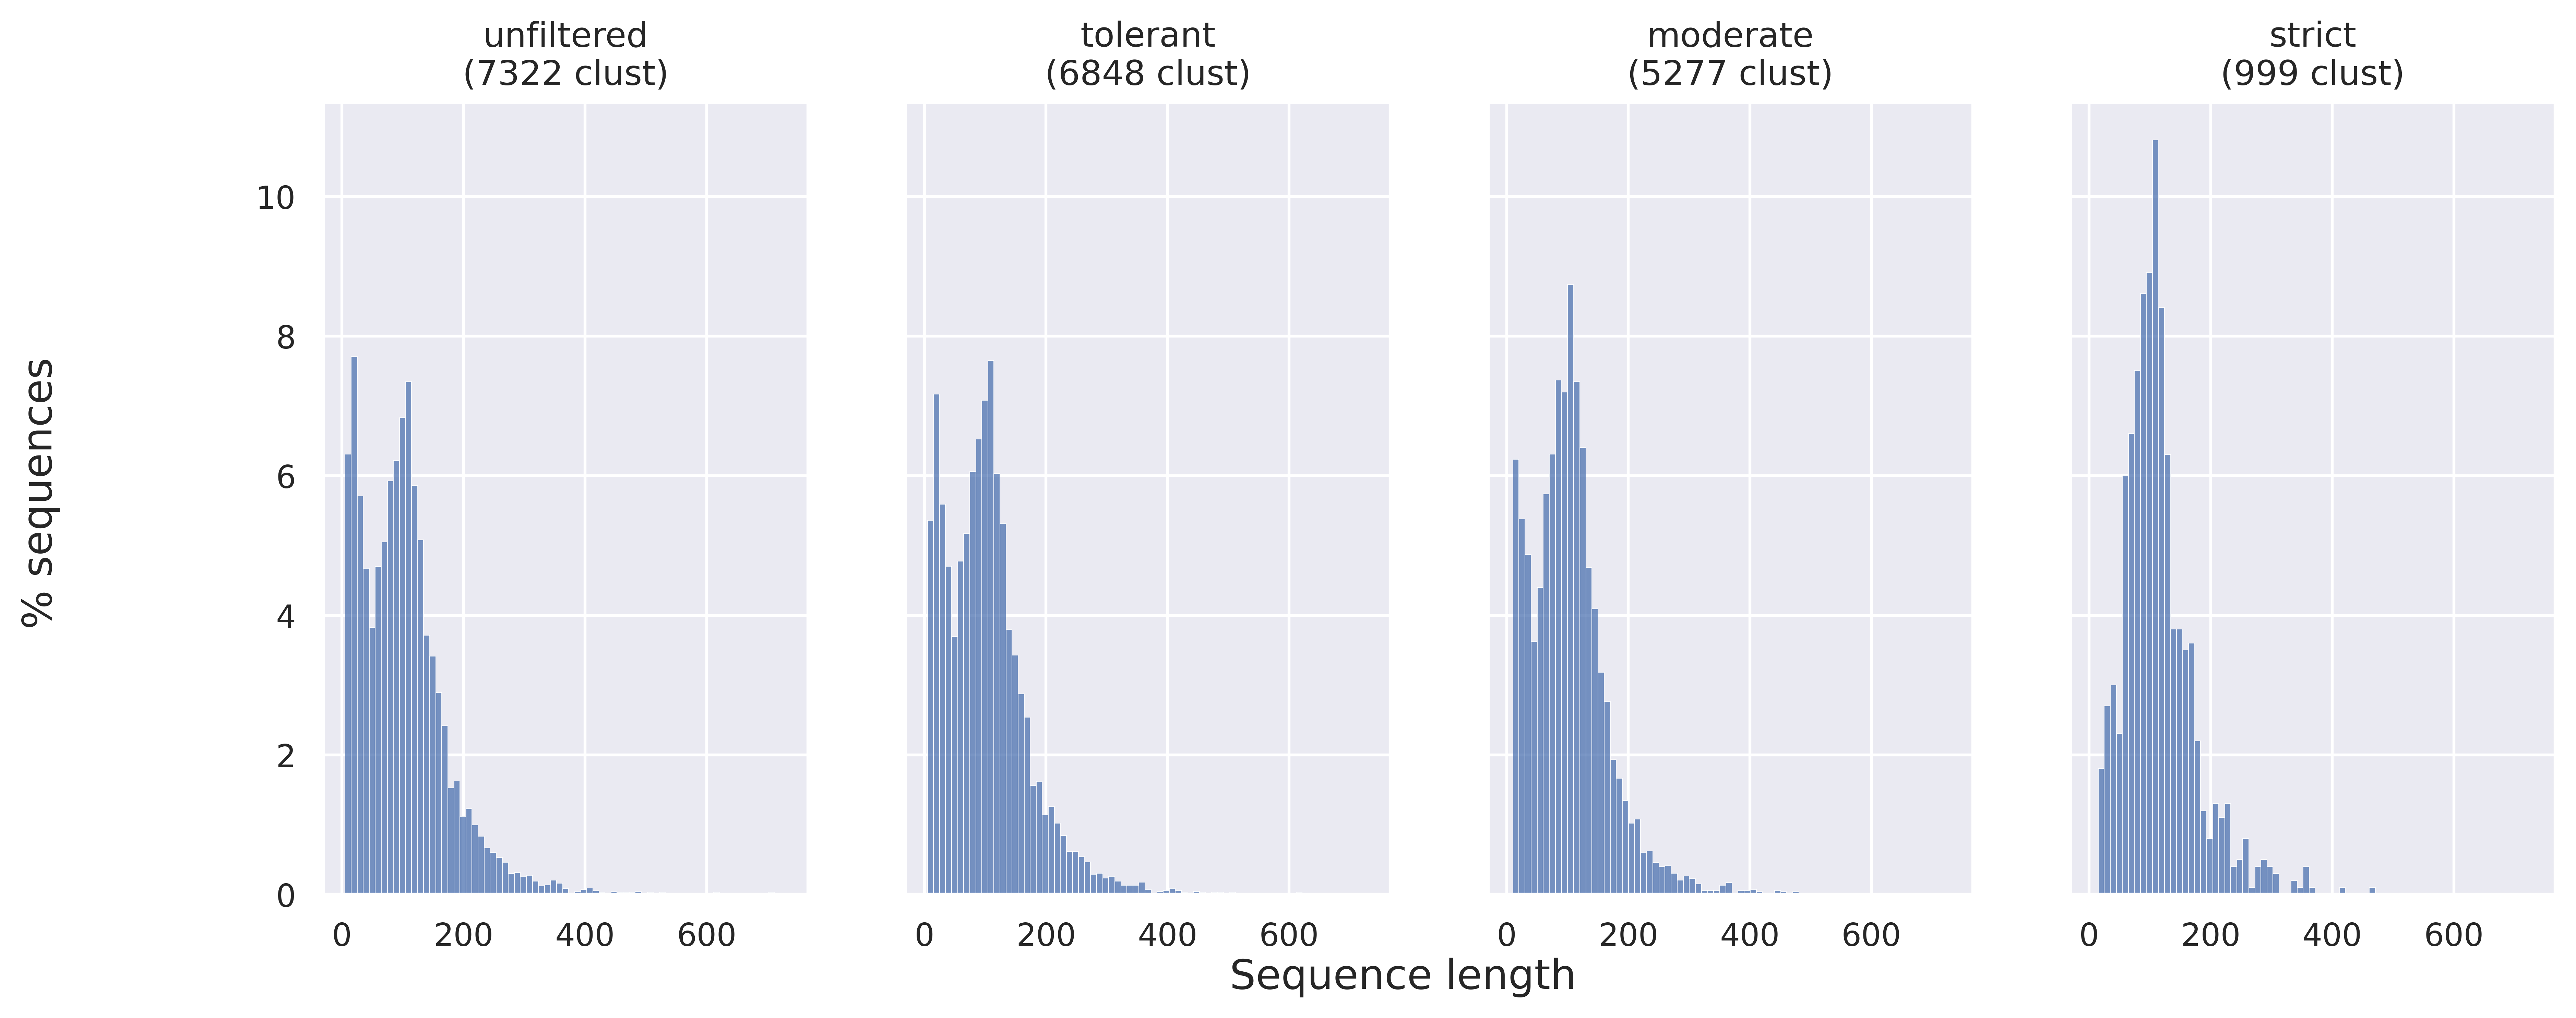

In [5]:
fig, axes = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=(14, 5), dpi=600)

for ax, dataset in zip(axes, datasets):
    lengths = [len(rec.seq) for rec in SeqIO.parse(f"data/{dataset}_rest_set.fasta", "fasta")]
    plt.sca(ax)
    plot = sns.histplot(lengths, binwidth=10, stat="percent")

    ax.set_title(f"{dataset}\n({len(lengths)} clust)")

    ax.set_xlabel(None)
    ax.set_ylabel(None)

fig.supxlabel("Sequence length")
fig.supylabel("% sequences")

### Disorder score distribution

Text(0.02, 0.5, '% residues')

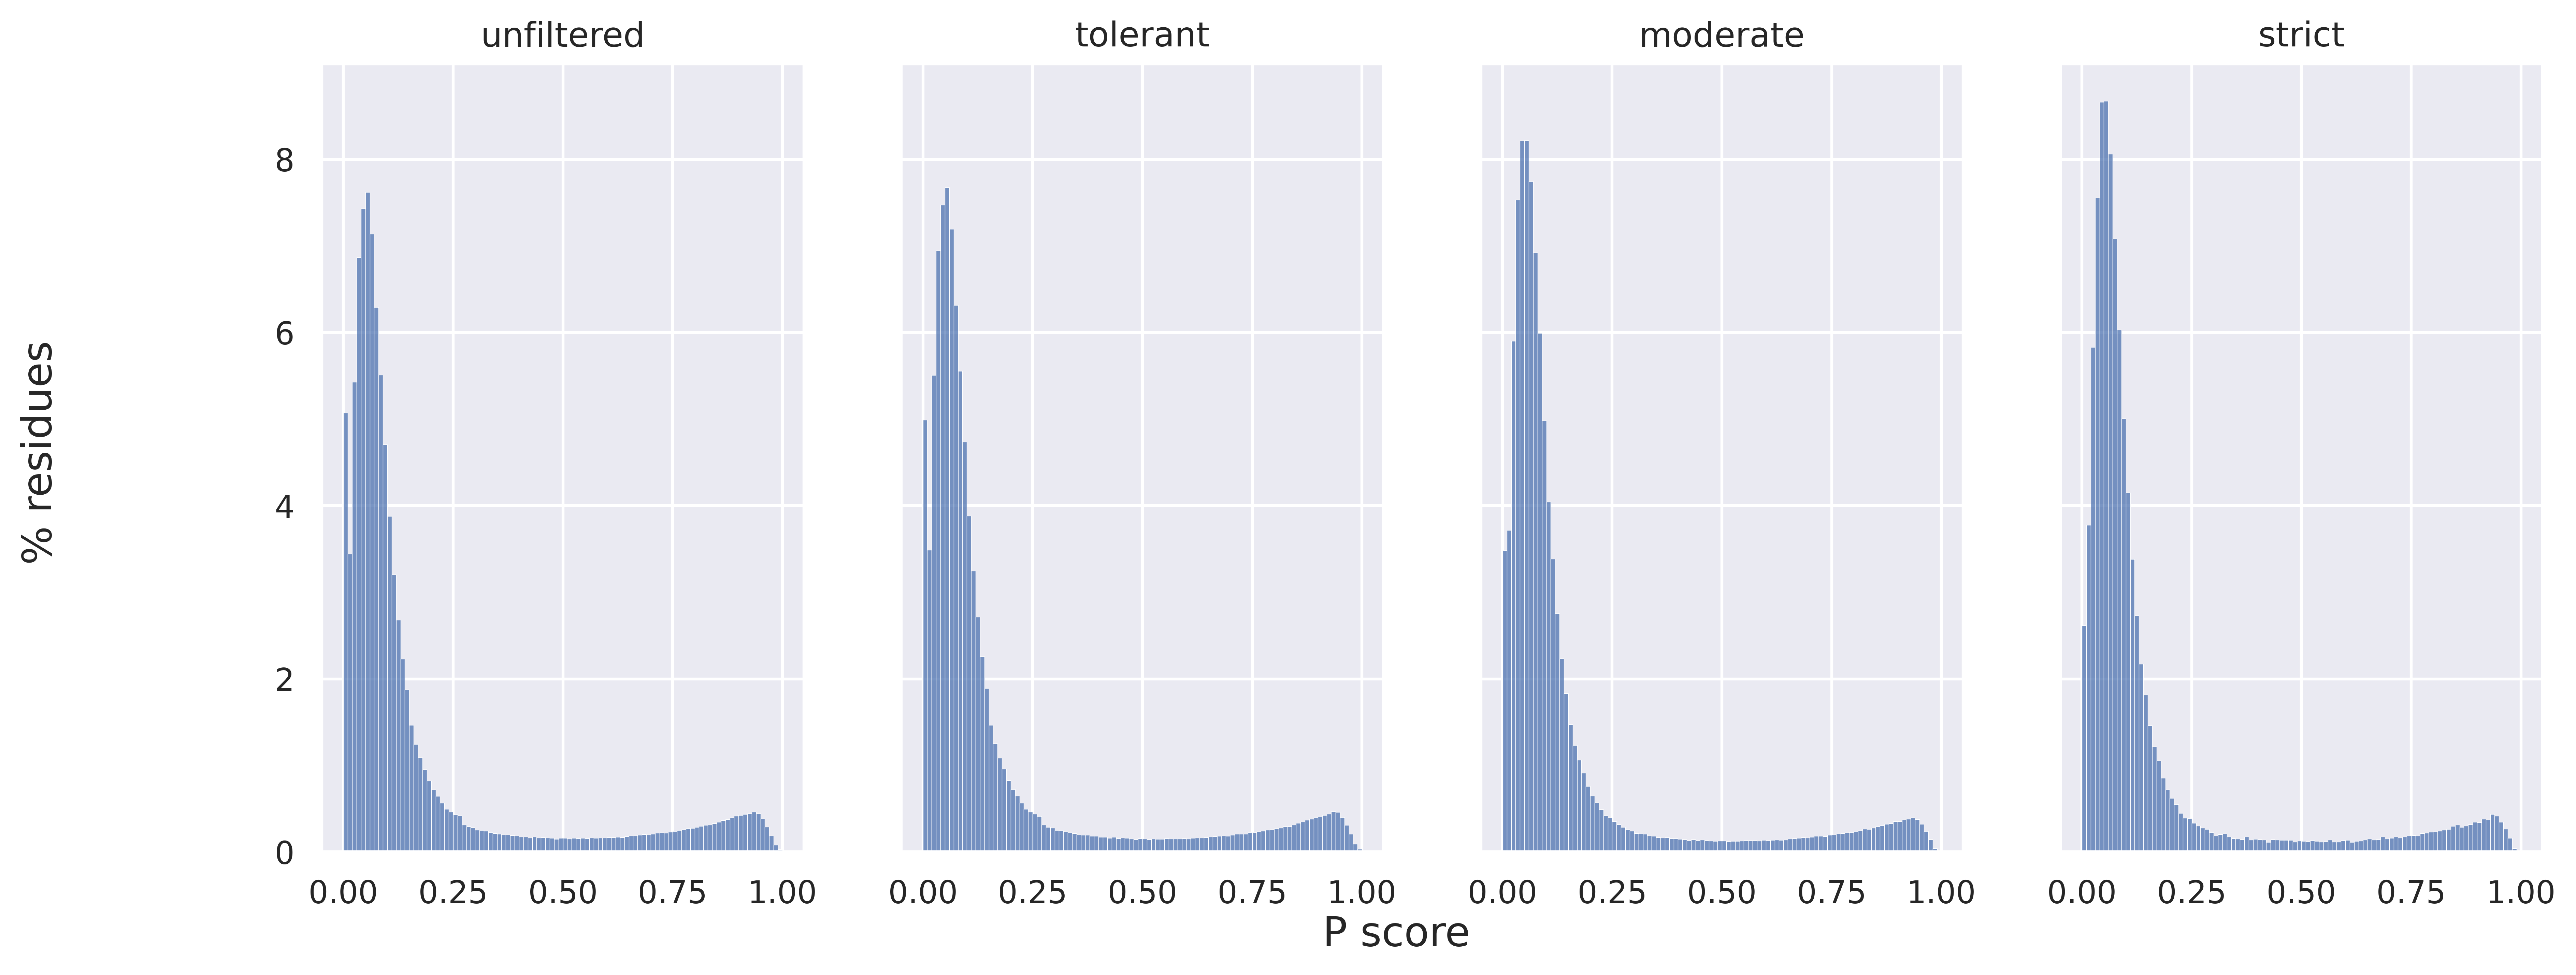

In [6]:
fig, axes = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=(14, 5), dpi=600)

for ax, dataset in zip(axes, datasets):
    df = read_score_csv(f"data/{dataset}.csv")
    plt.sca(ax)
    plot = df.sns.histplot(x="pscores", stat="percent", binwidth=.01, binrange=[0, 1])

    ax.set_title(dataset)

    ax.set_xlabel(None)
    ax.set_ylabel(None)

fig.supxlabel("P score")
fig.supylabel("% residues")

### Dataset filtering

In [7]:
for dataset in datasets:
    df = read_reference_json(f"data/{dataset}.json")
    print(dataset)
    print(f"pH: [{df['pH'].min()}, {df['pH'].max()}]")
    print(f"ionic_strength: [{df['ionic_strength'].min()}, {df['ionic_strength'].max()}]")
    print(f"temperature: [{df['temperature'].min()}, {df['temperature'].max()}]")

unfiltered
pH: [0.0, 291.0]
ionic_strength: [0.0, 5.0]
temperature: [110.0, 398.0]
tolerant
pH: [2.0, 11.1]
ionic_strength: [0.0, 4.2]
temperature: [268.0, 333.0]
moderate
pH: [4.0, 9.96]
ionic_strength: [0.0, 3.0]
temperature: [273.0, 313.0]
strict
pH: [6.0, 8.0]
ionic_strength: [0.0, 2.0]
temperature: [273.0, 313.0]


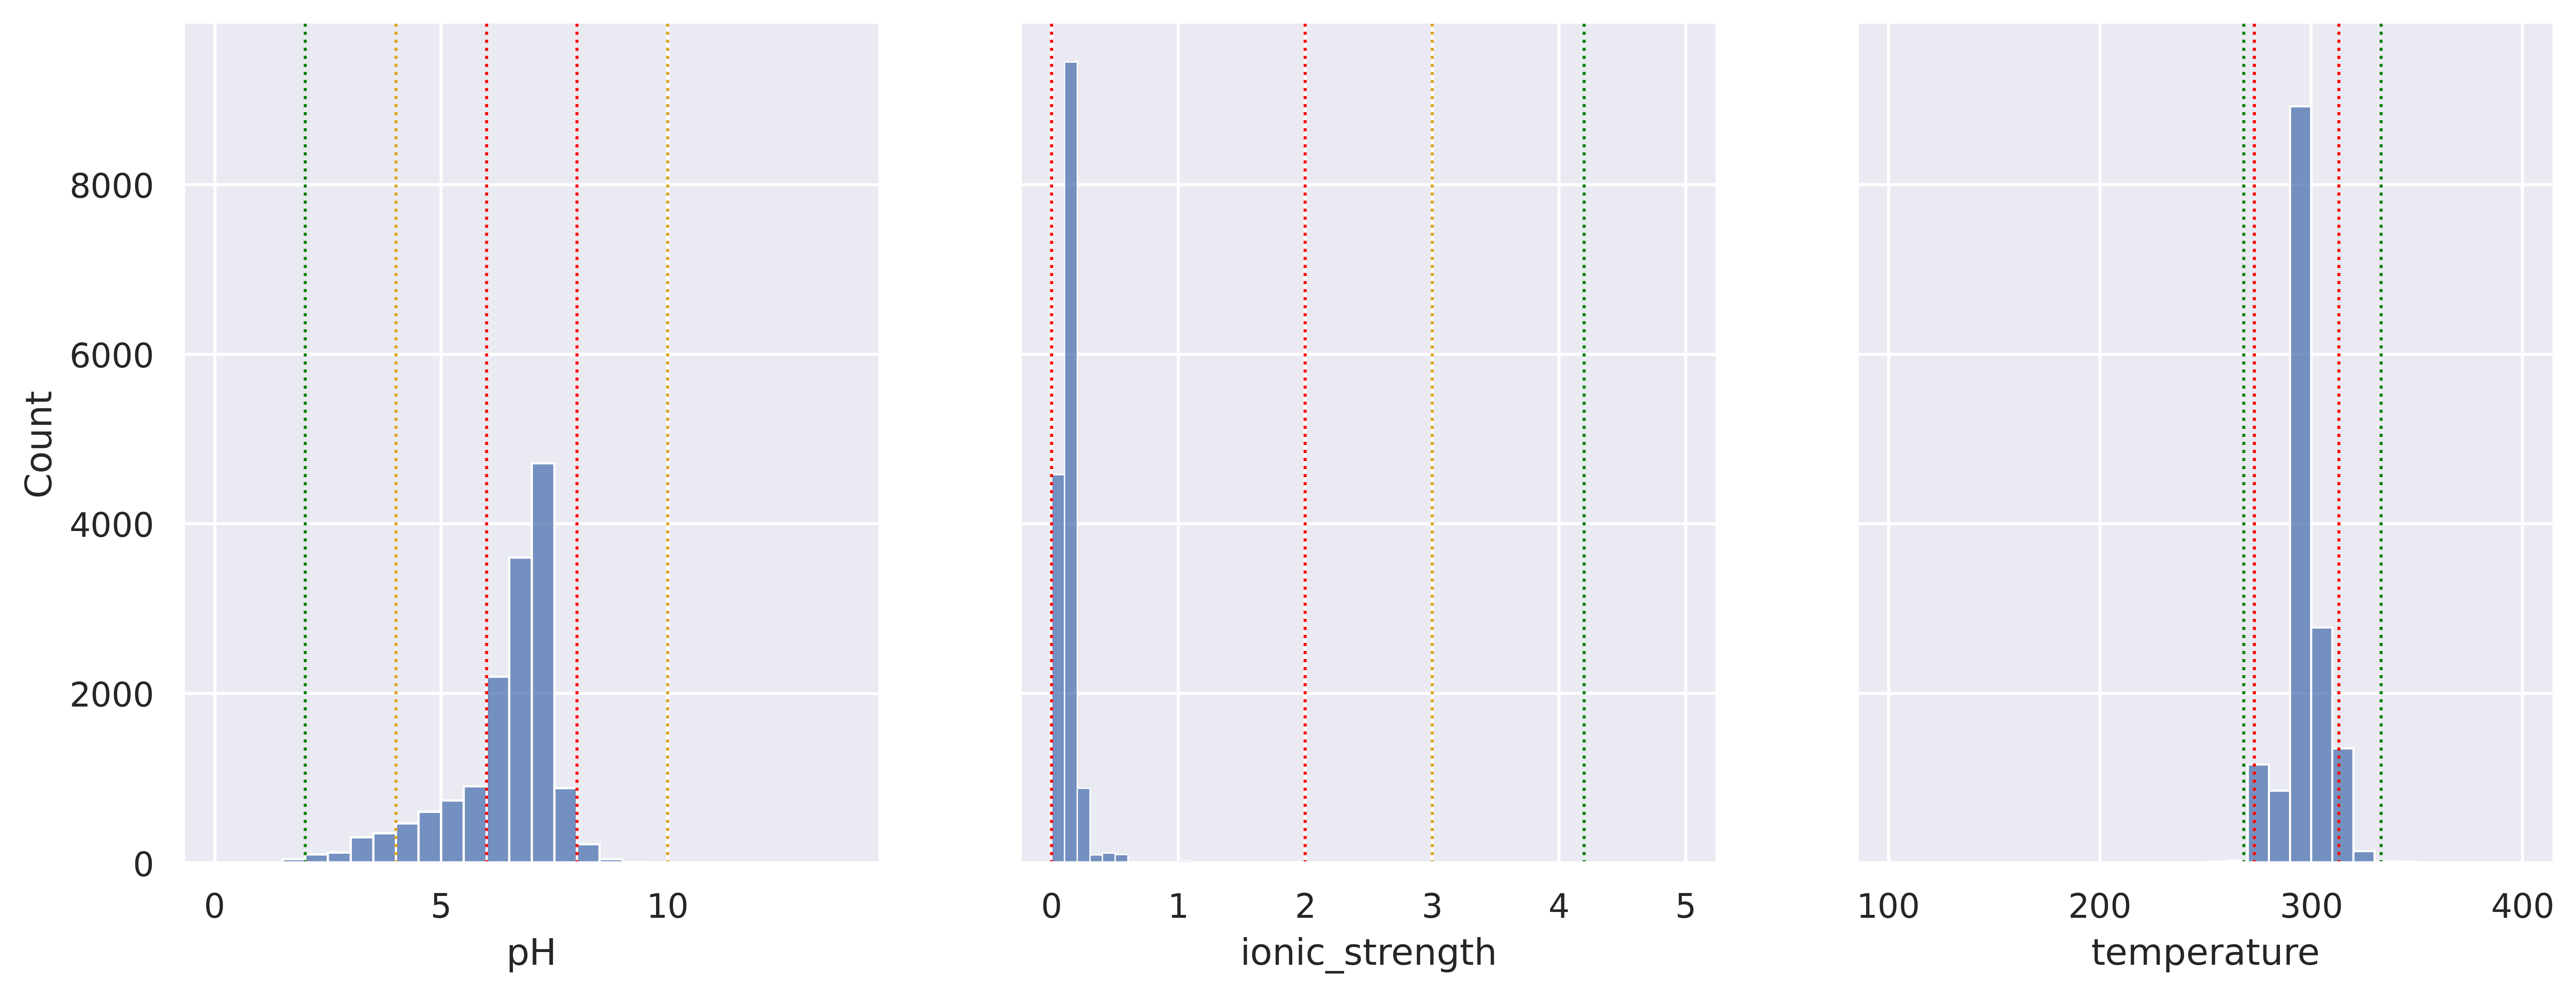

In [8]:
df = read_reference_json("data/unfiltered.json").select(["pH", "temperature", "ionic_strength"])
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(14, 5), dpi=600)

plt.sca(ax1)
plot = df.sns.histplot(x="pH", binwidth=.5, binrange=[0, 14])

tolerant_color, moderate_color, strict_color = ["green", "goldenrod", "red"]
linestyle = ':'
linewidth=1
line_args = {"linestyle": linestyle, "linewidth": linewidth}

ax1.axvline(x=2, color=tolerant_color, **line_args)
ax1.axvline(x=4, color=moderate_color, **line_args)
ax1.axvline(x=10, color=moderate_color, **line_args)
ax1.axvline(x=6, color=strict_color, **line_args)
ax1.axvline(x=8, color=strict_color, **line_args)

plt.sca(ax2)
plot = df.sns.histplot(x="ionic_strength", binwidth=.1, binrange=[0, 5])
ax2.axvline(x=0, color=strict_color, **line_args)
ax2.axvline(x=4.2, color=tolerant_color, **line_args)
ax2.axvline(x=3, color=moderate_color, **line_args)
ax2.axvline(x=2, color=strict_color, **line_args)

plt.sca(ax3)
plot = df.sns.histplot(x="temperature", binwidth=10, binrange=[100, 400])
ax3.axvline(x=268, color=tolerant_color, **line_args)
ax3.axvline(x=333, color=tolerant_color, **line_args)
ax3.axvline(x=273, color=moderate_color, **line_args)
ax3.axvline(x=313, color=moderate_color, **line_args)
ax3.axvline(x=273, color=strict_color, **line_args)
ax3.axvline(x=313, color=strict_color, **line_args)

### FASTA sizes

In [9]:
{
    fasta_path.stem:
    len([rec for rec in SeqIO.parse(fasta_path, "fasta")])
    for fasta_path in Path("./data").glob("*.fasta")
}

{'strict_rest_set': 999,
 'rr_CheZOD117_test_set': 115,
 'unfiltered_rest_set': 7322,
 'unfiltered_all': 15320,
 'moderate_rest_set': 5277,
 'tolerant_rest_set': 6848,
 'TriZOD_test_set': 348}